# Recurrent Neural Networks (RNN) with Keras

## Learning Objectives

1. Add built-in RNN layers.
2. Build bidirectional RNNs.
3. Using CuDNN kernels when available.
4. Build a RNN model with nested input/output.


## Introduction

Recurrent neural networks (RNN) are a class of neural networks that is powerful for
modeling sequence data such as time series or natural language.

Schematically, a RNN layer uses a `for` loop to iterate over the timesteps of a
sequence, while maintaining an internal state that encodes information about the
timesteps it has seen so far.

The Keras RNN API is designed with a focus on:

- **Ease of use**: the built-in `keras.layers.RNN`, `keras.layers.LSTM`,
`keras.layers.GRU` layers enable you to quickly build recurrent models without
having to make difficult configuration choices.

- **Ease of customization**: You can also define your own RNN cell layer (the inner
part of the `for` loop) with custom behavior, and use it with the generic
`keras.layers.RNN` layer (the `for` loop itself). This allows you to quickly
prototype different research ideas in a flexible way with minimal code.

Each learning objective will correspond to a __#TODO__ in the [student lab notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/deepdive2/text_classification/labs/rnn.ipynb) -- try to complete that notebook first before reviewing this solution notebook.

## Setup

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Built-in RNN layers: a simple example

There are three built-in RNN layers in Keras:

1. `keras.layers.SimpleRNN`, a fully-connected RNN where the output from previous
timestep is to be fed to next timestep.

2. `keras.layers.GRU`, first proposed in
[Cho et al., 2014](https://arxiv.org/abs/1406.1078).

3. `keras.layers.LSTM`, first proposed in
[Hochreiter & Schmidhuber, 1997](https://www.bioinf.jku.at/publications/older/2604.pdf).

In early 2015, Keras had the first reusable open-source Python implementations of LSTM
and GRU.

Here is a simple example of a `Sequential` model that processes sequences of integers,
embeds each integer into a 64-dimensional vector, then processes the sequence of
vectors using a `LSTM` layer.

In [3]:
model = keras.Sequential()
# Add an Embedding layer expecting input vocab of size 1000, and
# output embedding dimension of size 64.
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# Add a LSTM layer with 128 internal units.
# TODO
model.add(layers.LSTM(128))

# Add a Dense layer with 10 units.
# TODO
model.add(layers.Dense(10))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
lstm (LSTM)                  (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 10)                1290      
Total params: 164,106
Trainable params: 164,106
Non-trainable params: 0
_________________________________________________________________


Built-in RNNs support a number of useful features:

- Recurrent dropout, via the `dropout` and `recurrent_dropout` arguments
- Ability to process an input sequence in reverse, via the `go_backwards` argument
- Loop unrolling (which can lead to a large speedup when processing short sequences on
CPU), via the `unroll` argument
- ...and more.

For more information, see the
[RNN API documentation](https://keras.io/api/layers/recurrent_layers/).

## Outputs and states

By default, the output of a RNN layer contains a single vector per sample. This vector
is the RNN cell output corresponding to the last timestep, containing information
about the entire input sequence. The shape of this output is `(batch_size, units)`
where `units` corresponds to the `units` argument passed to the layer's constructor.

A RNN layer can also return the entire sequence of outputs for each sample (one vector
per timestep per sample), if you set `return_sequences=True`. The shape of this output
is `(batch_size, timesteps, units)`.

In [4]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=1000, output_dim=64))

# The output of GRU will be a 3D tensor of shape (batch_size, timesteps, 256)
model.add(layers.GRU(256, return_sequences=True))

# The output of SimpleRNN will be a 2D tensor of shape (batch_size, 128)
model.add(layers.SimpleRNN(128))

model.add(layers.Dense(10))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
gru (GRU)                    (None, None, 256)         247296    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 128)               49280     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 361,866
Trainable params: 361,866
Non-trainable params: 0
_________________________________________________________________


In addition, a RNN layer can return its final internal state(s). The returned states
can be used to resume the RNN execution later, or
[to initialize another RNN](https://arxiv.org/abs/1409.3215).
This setting is commonly used in the
encoder-decoder sequence-to-sequence model, where the encoder final state is used as
the initial state of the decoder.

To configure a RNN layer to return its internal state, set the `return_state` parameter
to `True` when creating the layer. Note that `LSTM` has 2 state  tensors, but `GRU`
only has one.

To configure the initial state of the layer, just call the layer with additional
keyword argument `initial_state`.
Note that the shape of the state needs to match the unit size of the layer, like in the
example below.

In [5]:
encoder_vocab = 1000
decoder_vocab = 2000

encoder_input = layers.Input(shape=(None,))
encoder_embedded = layers.Embedding(input_dim=encoder_vocab, output_dim=64)(
    encoder_input
)

# Return states in addition to output
output, state_h, state_c = layers.LSTM(64, return_state=True, name="encoder")(
    encoder_embedded
)
encoder_state = [state_h, state_c]

decoder_input = layers.Input(shape=(None,))
decoder_embedded = layers.Embedding(input_dim=decoder_vocab, output_dim=64)(
    decoder_input
)

# Pass the 2 states to a new LSTM layer, as initial state
decoder_output = layers.LSTM(64, name="decoder")(
    decoder_embedded, initial_state=encoder_state
)
output = layers.Dense(10)(decoder_output)

model = keras.Model([encoder_input, decoder_input], output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 64)     64000       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 64)     128000      input_2[0][0]                    
______________________________________________________________________________________________

## RNN layers and RNN cells

In addition to the built-in RNN layers, the RNN API also provides cell-level APIs.
Unlike RNN layers, which processes whole batches of input sequences, the RNN cell only
processes a single timestep.

The cell is the inside of the `for` loop of a RNN layer. Wrapping a cell inside a
`keras.layers.RNN` layer gives you a layer capable of processing batches of
sequences, e.g. `RNN(LSTMCell(10))`.

Mathematically, `RNN(LSTMCell(10))` produces the same result as `LSTM(10)`. In fact,
the implementation of this layer in TF v1.x was just creating the corresponding RNN
cell and wrapping it in a RNN layer.  However using the built-in `GRU` and `LSTM`
layers enable the use of CuDNN and you may see better performance.

There are three built-in RNN cells, each of them corresponding to the matching RNN
layer.

- `keras.layers.SimpleRNNCell` corresponds to the `SimpleRNN` layer.

- `keras.layers.GRUCell` corresponds to the `GRU` layer.

- `keras.layers.LSTMCell` corresponds to the `LSTM` layer.

The cell abstraction, together with the generic `keras.layers.RNN` class, make it
very easy to implement custom RNN architectures for your research.

## Cross-batch statefulness

When processing very long sequences (possibly infinite), you may want to use the
pattern of **cross-batch statefulness**.

Normally, the internal state of a RNN layer is reset every time it sees a new batch
(i.e. every sample seen by the layer is assumed to be independent of the past). The
layer will only maintain a state while processing a given sample.

If you have very long sequences though, it is useful to break them into shorter
sequences, and to feed these shorter sequences sequentially into a RNN layer without
resetting the layer's state. That way, the layer can retain information about the
entirety of the sequence, even though it's only seeing one sub-sequence at a time.

You can do this by setting `stateful=True` in the constructor.

If you have a sequence `s = [t0, t1, ... t1546, t1547]`, you would split it into e.g.

```
s1 = [t0, t1, ... t100]
s2 = [t101, ... t201]
...
s16 = [t1501, ... t1547]
```

Then you would process it via:

```python
lstm_layer = layers.LSTM(64, stateful=True)
for s in sub_sequences:
  output = lstm_layer(s)
```

When you want to clear the state, you  can use `layer.reset_states()`.


> Note: In this setup, sample `i` in a given batch is assumed to be the continuation of
sample `i` in the previous batch. This means that all batches should contain the same
number of samples (batch size). E.g. if a batch contains `[sequence_A_from_t0_to_t100,
 sequence_B_from_t0_to_t100]`, the next batch should contain
`[sequence_A_from_t101_to_t200,  sequence_B_from_t101_to_t200]`.




Here is a complete example:

In [6]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)
output = lstm_layer(paragraph3)

# reset_states() will reset the cached state to the original initial_state.
# If no initial_state was provided, zero-states will be used by default.
# TODO
lstm_layer.reset_states()


### RNN State Reuse
<a id="rnn_state_reuse"></a>

The recorded states of the RNN layer are not included in the `layer.weights()`. If you
would like to reuse the state from a RNN layer, you can retrieve the states value by
`layer.states` and use it as the
initial state for a new layer via the Keras functional API like `new_layer(inputs,
initial_state=layer.states)`, or model subclassing.

Please also note that sequential model might not be used in this case since it only
supports layers with single input and output, the extra input of initial state makes
it impossible to use here.

In [7]:
paragraph1 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph2 = np.random.random((20, 10, 50)).astype(np.float32)
paragraph3 = np.random.random((20, 10, 50)).astype(np.float32)

lstm_layer = layers.LSTM(64, stateful=True)
output = lstm_layer(paragraph1)
output = lstm_layer(paragraph2)

existing_state = lstm_layer.states

new_lstm_layer = layers.LSTM(64)
new_output = new_lstm_layer(paragraph3, initial_state=existing_state)


## Bidirectional RNNs

For sequences other than time series (e.g. text), it is often the case that a RNN model
can perform better if it not only processes sequence from start to end, but also
backwards. For example, to predict the next word in a sentence, it is often useful to
have the context around the word, not only just the words that come before it.

Keras provides an easy API for you to build such bidirectional RNNs: the
`keras.layers.Bidirectional` wrapper.

In [8]:
model = keras.Sequential()

# Add Bidirectional layers
# TODO
model.add(
    layers.Bidirectional(layers.LSTM(64, return_sequences=True), input_shape=(5, 10))
)
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(10))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 5, 128)            38400     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 80,266
Trainable params: 80,266
Non-trainable params: 0
_________________________________________________________________


Under the hood, `Bidirectional` will copy the RNN layer passed in, and flip the
`go_backwards` field of the newly copied layer, so that it will process the inputs in
reverse order.

The output of the `Bidirectional` RNN will be, by default, the concatenation of the forward layer
output and the backward layer output. If you need a different merging behavior, e.g.
concatenation, change the `merge_mode` parameter in the `Bidirectional` wrapper
constructor. For more details about `Bidirectional`, please check
[the API docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional/).

## Performance optimization and CuDNN kernels

In TensorFlow 2.0, the built-in LSTM and GRU layers have been updated to leverage CuDNN
kernels by default when a GPU is available. With this change, the prior
`keras.layers.CuDNNLSTM/CuDNNGRU` layers have been deprecated, and you can build your
model without worrying about the hardware it will run on.

Since the CuDNN kernel is built with certain assumptions, this means the layer **will
not be able to use the CuDNN kernel if you change the defaults of the built-in LSTM or
GRU layers**. E.g.:

- Changing the `activation` function from `tanh` to something else.
- Changing the `recurrent_activation` function from `sigmoid` to something else.
- Using `recurrent_dropout` > 0.
- Setting `unroll` to True, which forces LSTM/GRU to decompose the inner
`tf.while_loop` into an unrolled `for` loop.
- Setting `use_bias` to False.
- Using masking when the input data is not strictly right padded (if the mask
corresponds to strictly right padded data, CuDNN can still be used. This is the most
common case).

For the detailed list of constraints, please see the documentation for the
[LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM/) and
[GRU](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU/) layers.

### Using CuDNN kernels when available

Let's build a simple LSTM model to demonstrate the performance difference.

We'll use as input sequences the sequence of rows of MNIST digits (treating each row of
pixels as a timestep), and we'll predict the digit's label.

In [9]:
batch_size = 64
# Each MNIST image batch is a tensor of shape (batch_size, 28, 28).
# Each input sequence will be of size (28, 28) (height is treated like time).
input_dim = 28

units = 64
output_size = 10  # labels are from 0 to 9

# Build the RNN model
def build_model(allow_cudnn_kernel=True):
    # CuDNN is only available at the layer level, and not at the cell level.
    # This means `LSTM(units)` will use the CuDNN kernel,
    # while RNN(LSTMCell(units)) will run on non-CuDNN kernel.
    if allow_cudnn_kernel:
        # The LSTM layer with default options uses CuDNN.
        lstm_layer = keras.layers.LSTM(units, input_shape=(None, input_dim))
    else:
        # Wrapping a LSTMCell in a RNN layer will not use CuDNN.
        lstm_layer = keras.layers.RNN(
            keras.layers.LSTMCell(units), input_shape=(None, input_dim)
        )
    model = keras.models.Sequential(
        [
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(output_size),
        ]
    )
    return model


Let's load the MNIST dataset:

In [10]:
mnist = keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
sample, sample_label = x_train[0], y_train[0]

    8192/11490434 [..............................] - ETA: 0s

 4202496/11490434 [=========>....................] - ETA: 0s

 8396800/11490434 [====================>.........] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


Let's create a model instance and train it.

We choose `sparse_categorical_crossentropy` as the loss function for the model. The
output of the model has shape of `[batch_size, 10]`. The target for the model is an
integer vector, each of the integer is in the range of 0 to 9.

In [11]:
model = build_model(allow_cudnn_kernel=True)

# Compile the model
# TODO
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)


model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

  1/938 [..............................] - ETA: 25:36 - loss: 2.6726 - accuracy: 0.1094

 14/938 [..............................] - ETA: 3s - loss: 2.3320 - accuracy: 0.1873   

 27/938 [..............................] - ETA: 3s - loss: 2.2306 - accuracy: 0.2171

 40/938 [>.............................] - ETA: 3s - loss: 2.1573 - accuracy: 0.2420

 53/938 [>.............................] - ETA: 3s - loss: 2.1006 - accuracy: 0.2626

 65/938 [=>............................] - ETA: 3s - loss: 2.0576 - accuracy: 0.2783

 77/938 [=>............................] - ETA: 3s - loss: 2.0201 - accuracy: 0.2927

 90/938 [=>............................] - ETA: 3s - loss: 1.9838 - accuracy: 0.3071

103/938 [==>...........................] - ETA: 3s - loss: 1.9510 - accuracy: 0.3203

116/938 [==>...........................] - ETA: 3s - loss: 1.9215 - accuracy: 0.3324

128/938 [===>..........................] - ETA: 3s - loss: 1.8964 - accuracy: 0.3428

141/938 [===>..........................] - ETA: 3s - loss: 1.8716 - accuracy: 0.3531

154/938 [===>..........................] - ETA: 3s - loss: 1.8487 - accuracy: 0.3627

167/938 [====>.........................] - ETA: 3s - loss: 1.8274 - accuracy: 0.3715

181/938 [====>.........................] - ETA: 3s - loss: 1.8058 - accuracy: 0.3806

195/938 [=====>........................] - ETA: 3s - loss: 1.7854 - accuracy: 0.3893

208/938 [=====>........................] - ETA: 2s - loss: 1.7675 - accuracy: 0.3967

221/938 [======>.......................] - ETA: 2s - loss: 1.7505 - accuracy: 0.4038

233/938 [======>.......................] - ETA: 2s - loss: 1.7355 - accuracy: 0.4100

245/938 [======>.......................] - ETA: 2s - loss: 1.7212 - accuracy: 0.4159

258/938 [=======>......................] - ETA: 2s - loss: 1.7064 - accuracy: 0.4219

271/938 [=======>......................] - ETA: 2s - loss: 1.6923 - accuracy: 0.4276

284/938 [========>.....................] - ETA: 2s - loss: 1.6788 - accuracy: 0.4331

297/938 [========>.....................] - ETA: 2s - loss: 1.6657 - accuracy: 0.4382

310/938 [========>.....................] - ETA: 2s - loss: 1.6531 - accuracy: 0.4432

323/938 [=========>....................] - ETA: 2s - loss: 1.6410 - accuracy: 0.4479

337/938 [=========>....................] - ETA: 2s - loss: 1.6285 - accuracy: 0.4529

350/938 [==========>...................] - ETA: 2s - loss: 1.6172 - accuracy: 0.4572

363/938 [==========>...................] - ETA: 2s - loss: 1.6062 - accuracy: 0.4615

376/938 [===========>..................] - ETA: 2s - loss: 1.5956 - accuracy: 0.4656

389/938 [===========>..................] - ETA: 2s - loss: 1.5852 - accuracy: 0.4695

402/938 [===========>..................] - ETA: 2s - loss: 1.5751 - accuracy: 0.4734

415/938 [============>.................] - ETA: 2s - loss: 1.5652 - accuracy: 0.4771

428/938 [============>.................] - ETA: 2s - loss: 1.5556 - accuracy: 0.4808

441/938 [=============>................] - ETA: 1s - loss: 1.5462 - accuracy: 0.4843

454/938 [=============>................] - ETA: 1s - loss: 1.5371 - accuracy: 0.4878

467/938 [=============>................] - ETA: 1s - loss: 1.5281 - accuracy: 0.4912

480/938 [==============>...............] - ETA: 1s - loss: 1.5193 - accuracy: 0.4945

493/938 [==============>...............] - ETA: 1s - loss: 1.5107 - accuracy: 0.4977

506/938 [===============>..............] - ETA: 1s - loss: 1.5023 - accuracy: 0.5008

519/938 [===============>..............] - ETA: 1s - loss: 1.4941 - accuracy: 0.5039

532/938 [================>.............] - ETA: 1s - loss: 1.4860 - accuracy: 0.5069

545/938 [================>.............] - ETA: 1s - loss: 1.4780 - accuracy: 0.5099

558/938 [================>.............] - ETA: 1s - loss: 1.4702 - accuracy: 0.5128

571/938 [=================>............] - ETA: 1s - loss: 1.4625 - accuracy: 0.5156

585/938 [=================>............] - ETA: 1s - loss: 1.4543 - accuracy: 0.5186

598/938 [==================>...........] - ETA: 1s - loss: 1.4469 - accuracy: 0.5213

611/938 [==================>...........] - ETA: 1s - loss: 1.4396 - accuracy: 0.5240

624/938 [==================>...........] - ETA: 1s - loss: 1.4325 - accuracy: 0.5267

638/938 [===================>..........] - ETA: 1s - loss: 1.4249 - accuracy: 0.5294

651/938 [===================>..........] - ETA: 1s - loss: 1.4180 - accuracy: 0.5319

663/938 [====================>.........] - ETA: 1s - loss: 1.4118 - accuracy: 0.5342

676/938 [====================>.........] - ETA: 1s - loss: 1.4051 - accuracy: 0.5366

690/938 [=====================>........] - ETA: 0s - loss: 1.3981 - accuracy: 0.5392

703/938 [=====================>........] - ETA: 0s - loss: 1.3916 - accuracy: 0.5415

716/938 [=====================>........] - ETA: 0s - loss: 1.3853 - accuracy: 0.5438

729/938 [======================>.......] - ETA: 0s - loss: 1.3791 - accuracy: 0.5461

742/938 [======================>.......] - ETA: 0s - loss: 1.3729 - accuracy: 0.5483

755/938 [=======================>......] - ETA: 0s - loss: 1.3669 - accuracy: 0.5504

768/938 [=======================>......] - ETA: 0s - loss: 1.3609 - accuracy: 0.5526

782/938 [========================>.....] - ETA: 0s - loss: 1.3546 - accuracy: 0.5548

795/938 [========================>.....] - ETA: 0s - loss: 1.3489 - accuracy: 0.5569

808/938 [========================>.....] - ETA: 0s - loss: 1.3432 - accuracy: 0.5590

822/938 [=========================>....] - ETA: 0s - loss: 1.3372 - accuracy: 0.5611

836/938 [=========================>....] - ETA: 0s - loss: 1.3312 - accuracy: 0.5632

849/938 [==========================>...] - ETA: 0s - loss: 1.3258 - accuracy: 0.5652

863/938 [==========================>...] - ETA: 0s - loss: 1.3200 - accuracy: 0.5672

877/938 [===========================>..] - ETA: 0s - loss: 1.3143 - accuracy: 0.5693

890/938 [===========================>..] - ETA: 0s - loss: 1.3091 - accuracy: 0.5711

903/938 [===========================>..] - ETA: 0s - loss: 1.3039 - accuracy: 0.5729

916/938 [============================>.] - ETA: 0s - loss: 1.2988 - accuracy: 0.5747

929/938 [============================>.] - ETA: 0s - loss: 1.2938 - accuracy: 0.5765

938/938 [==============================] - 6s 5ms/step - loss: 1.2900 - accuracy: 0.5779 - val_loss: 0.5115 - val_accuracy: 0.8402


Now, let's compare to a model that does not use the CuDNN kernel:

In [12]:
noncudnn_model = build_model(allow_cudnn_kernel=False)
noncudnn_model.set_weights(model.get_weights())
noncudnn_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="sgd",
    metrics=["accuracy"],
)
noncudnn_model.fit(
    x_train, y_train, validation_data=(x_test, y_test), batch_size=batch_size, epochs=1
)

  1/938 [..............................] - ETA: 14:29 - loss: 0.5367 - accuracy: 0.8125

  3/938 [..............................] - ETA: 29s - loss: 0.5573 - accuracy: 0.7969  

  5/938 [..............................] - ETA: 30s - loss: 0.5480 - accuracy: 0.8045

  7/938 [..............................] - ETA: 29s - loss: 0.5434 - accuracy: 0.8073

  9/938 [..............................] - ETA: 29s - loss: 0.5405 - accuracy: 0.8105

 11/938 [..............................] - ETA: 29s - loss: 0.5406 - accuracy: 0.8126

 13/938 [..............................] - ETA: 29s - loss: 0.5399 - accuracy: 0.8147

 15/938 [..............................] - ETA: 29s - loss: 0.5391 - accuracy: 0.8162

 17/938 [..............................] - ETA: 28s - loss: 0.5371 - accuracy: 0.8181

 19/938 [..............................] - ETA: 28s - loss: 0.5347 - accuracy: 0.8199

 21/938 [..............................] - ETA: 29s - loss: 0.5326 - accuracy: 0.8218

 23/938 [..............................] - ETA: 28s - loss: 0.5312 - accuracy: 0.8232

 25/938 [..............................] - ETA: 28s - loss: 0.5304 - accuracy: 0.8243

 27/938 [..............................] - ETA: 28s - loss: 0.5300 - accuracy: 0.8252

 29/938 [..............................] - ETA: 29s - loss: 0.5300 - accuracy: 0.8258

 31/938 [..............................] - ETA: 28s - loss: 0.5299 - accuracy: 0.8264

 33/938 [>.............................] - ETA: 28s - loss: 0.5298 - accuracy: 0.8269

 35/938 [>.............................] - ETA: 28s - loss: 0.5297 - accuracy: 0.8274

 37/938 [>.............................] - ETA: 28s - loss: 0.5296 - accuracy: 0.8279

 39/938 [>.............................] - ETA: 28s - loss: 0.5294 - accuracy: 0.8283

 41/938 [>.............................] - ETA: 28s - loss: 0.5292 - accuracy: 0.8286

 43/938 [>.............................] - ETA: 28s - loss: 0.5287 - accuracy: 0.8290

 45/938 [>.............................] - ETA: 28s - loss: 0.5282 - accuracy: 0.8294

 47/938 [>.............................] - ETA: 28s - loss: 0.5277 - accuracy: 0.8298

 49/938 [>.............................] - ETA: 28s - loss: 0.5273 - accuracy: 0.8300

 51/938 [>.............................] - ETA: 28s - loss: 0.5269 - accuracy: 0.8302

 53/938 [>.............................] - ETA: 28s - loss: 0.5265 - accuracy: 0.8305

 55/938 [>.............................] - ETA: 28s - loss: 0.5263 - accuracy: 0.8307

 57/938 [>.............................] - ETA: 28s - loss: 0.5260 - accuracy: 0.8309

 59/938 [>.............................] - ETA: 28s - loss: 0.5258 - accuracy: 0.8310

 61/938 [>.............................] - ETA: 28s - loss: 0.5258 - accuracy: 0.8312

 63/938 [=>............................] - ETA: 27s - loss: 0.5256 - accuracy: 0.8313

 65/938 [=>............................] - ETA: 27s - loss: 0.5254 - accuracy: 0.8315

 67/938 [=>............................] - ETA: 27s - loss: 0.5253 - accuracy: 0.8316

 69/938 [=>............................] - ETA: 27s - loss: 0.5251 - accuracy: 0.8317

 71/938 [=>............................] - ETA: 27s - loss: 0.5249 - accuracy: 0.8318

 73/938 [=>............................] - ETA: 27s - loss: 0.5247 - accuracy: 0.8319

 75/938 [=>............................] - ETA: 27s - loss: 0.5246 - accuracy: 0.8320

 77/938 [=>............................] - ETA: 27s - loss: 0.5246 - accuracy: 0.8321

 79/938 [=>............................] - ETA: 27s - loss: 0.5245 - accuracy: 0.8322

 81/938 [=>............................] - ETA: 27s - loss: 0.5245 - accuracy: 0.8322

 83/938 [=>............................] - ETA: 27s - loss: 0.5243 - accuracy: 0.8323

 85/938 [=>............................] - ETA: 27s - loss: 0.5242 - accuracy: 0.8324

 87/938 [=>............................] - ETA: 27s - loss: 0.5241 - accuracy: 0.8324

 89/938 [=>............................] - ETA: 27s - loss: 0.5240 - accuracy: 0.8325

 91/938 [=>............................] - ETA: 27s - loss: 0.5239 - accuracy: 0.8325

 93/938 [=>............................] - ETA: 27s - loss: 0.5238 - accuracy: 0.8326

 95/938 [==>...........................] - ETA: 27s - loss: 0.5237 - accuracy: 0.8327

 97/938 [==>...........................] - ETA: 27s - loss: 0.5236 - accuracy: 0.8327

 99/938 [==>...........................] - ETA: 27s - loss: 0.5235 - accuracy: 0.8328

101/938 [==>...........................] - ETA: 26s - loss: 0.5234 - accuracy: 0.8329

103/938 [==>...........................] - ETA: 26s - loss: 0.5233 - accuracy: 0.8330

105/938 [==>...........................] - ETA: 26s - loss: 0.5232 - accuracy: 0.8331

107/938 [==>...........................] - ETA: 26s - loss: 0.5231 - accuracy: 0.8332

109/938 [==>...........................] - ETA: 26s - loss: 0.5230 - accuracy: 0.8333

111/938 [==>...........................] - ETA: 26s - loss: 0.5228 - accuracy: 0.8334

113/938 [==>...........................] - ETA: 26s - loss: 0.5227 - accuracy: 0.8335

115/938 [==>...........................] - ETA: 26s - loss: 0.5226 - accuracy: 0.8336

117/938 [==>...........................] - ETA: 26s - loss: 0.5224 - accuracy: 0.8338

119/938 [==>...........................] - ETA: 26s - loss: 0.5223 - accuracy: 0.8339

121/938 [==>...........................] - ETA: 26s - loss: 0.5221 - accuracy: 0.8340

123/938 [==>...........................] - ETA: 26s - loss: 0.5220 - accuracy: 0.8341

125/938 [==>...........................] - ETA: 26s - loss: 0.5218 - accuracy: 0.8342

127/938 [===>..........................] - ETA: 25s - loss: 0.5217 - accuracy: 0.8343

129/938 [===>..........................] - ETA: 25s - loss: 0.5215 - accuracy: 0.8344

131/938 [===>..........................] - ETA: 25s - loss: 0.5213 - accuracy: 0.8346

133/938 [===>..........................] - ETA: 25s - loss: 0.5211 - accuracy: 0.8347

135/938 [===>..........................] - ETA: 25s - loss: 0.5209 - accuracy: 0.8348

137/938 [===>..........................] - ETA: 25s - loss: 0.5207 - accuracy: 0.8349

139/938 [===>..........................] - ETA: 25s - loss: 0.5205 - accuracy: 0.8351

141/938 [===>..........................] - ETA: 25s - loss: 0.5203 - accuracy: 0.8352

143/938 [===>..........................] - ETA: 25s - loss: 0.5201 - accuracy: 0.8353

145/938 [===>..........................] - ETA: 25s - loss: 0.5199 - accuracy: 0.8354

147/938 [===>..........................] - ETA: 25s - loss: 0.5197 - accuracy: 0.8356

149/938 [===>..........................] - ETA: 25s - loss: 0.5195 - accuracy: 0.8357

151/938 [===>..........................] - ETA: 25s - loss: 0.5193 - accuracy: 0.8358

153/938 [===>..........................] - ETA: 25s - loss: 0.5190 - accuracy: 0.8359

155/938 [===>..........................] - ETA: 24s - loss: 0.5188 - accuracy: 0.8360

157/938 [====>.........................] - ETA: 24s - loss: 0.5186 - accuracy: 0.8362

159/938 [====>.........................] - ETA: 24s - loss: 0.5184 - accuracy: 0.8363

161/938 [====>.........................] - ETA: 24s - loss: 0.5181 - accuracy: 0.8364

163/938 [====>.........................] - ETA: 24s - loss: 0.5179 - accuracy: 0.8365

165/938 [====>.........................] - ETA: 24s - loss: 0.5177 - accuracy: 0.8366

167/938 [====>.........................] - ETA: 24s - loss: 0.5175 - accuracy: 0.8367

169/938 [====>.........................] - ETA: 24s - loss: 0.5173 - accuracy: 0.8368

171/938 [====>.........................] - ETA: 24s - loss: 0.5171 - accuracy: 0.8369

173/938 [====>.........................] - ETA: 24s - loss: 0.5169 - accuracy: 0.8370

175/938 [====>.........................] - ETA: 24s - loss: 0.5167 - accuracy: 0.8371

177/938 [====>.........................] - ETA: 24s - loss: 0.5166 - accuracy: 0.8372

179/938 [====>.........................] - ETA: 24s - loss: 0.5164 - accuracy: 0.8373

181/938 [====>.........................] - ETA: 24s - loss: 0.5162 - accuracy: 0.8374

183/938 [====>.........................] - ETA: 24s - loss: 0.5160 - accuracy: 0.8375

185/938 [====>.........................] - ETA: 24s - loss: 0.5158 - accuracy: 0.8376

187/938 [====>.........................] - ETA: 24s - loss: 0.5156 - accuracy: 0.8377

189/938 [=====>........................] - ETA: 23s - loss: 0.5154 - accuracy: 0.8378

191/938 [=====>........................] - ETA: 23s - loss: 0.5152 - accuracy: 0.8379

193/938 [=====>........................] - ETA: 23s - loss: 0.5151 - accuracy: 0.8380

195/938 [=====>........................] - ETA: 23s - loss: 0.5149 - accuracy: 0.8381

197/938 [=====>........................] - ETA: 23s - loss: 0.5147 - accuracy: 0.8382

199/938 [=====>........................] - ETA: 23s - loss: 0.5145 - accuracy: 0.8383

201/938 [=====>........................] - ETA: 23s - loss: 0.5143 - accuracy: 0.8384

203/938 [=====>........................] - ETA: 23s - loss: 0.5141 - accuracy: 0.8385

205/938 [=====>........................] - ETA: 23s - loss: 0.5139 - accuracy: 0.8386

207/938 [=====>........................] - ETA: 23s - loss: 0.5138 - accuracy: 0.8387

209/938 [=====>........................] - ETA: 23s - loss: 0.5136 - accuracy: 0.8388

211/938 [=====>........................] - ETA: 23s - loss: 0.5134 - accuracy: 0.8389

213/938 [=====>........................] - ETA: 23s - loss: 0.5131 - accuracy: 0.8390

215/938 [=====>........................] - ETA: 23s - loss: 0.5129 - accuracy: 0.8391

217/938 [=====>........................] - ETA: 22s - loss: 0.5127 - accuracy: 0.8392

219/938 [======>.......................] - ETA: 22s - loss: 0.5125 - accuracy: 0.8393

221/938 [======>.......................] - ETA: 22s - loss: 0.5123 - accuracy: 0.8394

223/938 [======>.......................] - ETA: 22s - loss: 0.5121 - accuracy: 0.8395

225/938 [======>.......................] - ETA: 22s - loss: 0.5118 - accuracy: 0.8396

227/938 [======>.......................] - ETA: 22s - loss: 0.5116 - accuracy: 0.8397

229/938 [======>.......................] - ETA: 22s - loss: 0.5113 - accuracy: 0.8398

231/938 [======>.......................] - ETA: 22s - loss: 0.5111 - accuracy: 0.8399

233/938 [======>.......................] - ETA: 22s - loss: 0.5109 - accuracy: 0.8400

235/938 [======>.......................] - ETA: 22s - loss: 0.5106 - accuracy: 0.8401

237/938 [======>.......................] - ETA: 22s - loss: 0.5104 - accuracy: 0.8402

239/938 [======>.......................] - ETA: 22s - loss: 0.5102 - accuracy: 0.8403

241/938 [======>.......................] - ETA: 22s - loss: 0.5099 - accuracy: 0.8404

243/938 [======>.......................] - ETA: 22s - loss: 0.5097 - accuracy: 0.8405

245/938 [======>.......................] - ETA: 22s - loss: 0.5095 - accuracy: 0.8406

247/938 [======>.......................] - ETA: 22s - loss: 0.5092 - accuracy: 0.8407

249/938 [======>.......................] - ETA: 22s - loss: 0.5090 - accuracy: 0.8408

251/938 [=======>......................] - ETA: 22s - loss: 0.5088 - accuracy: 0.8409

253/938 [=======>......................] - ETA: 21s - loss: 0.5086 - accuracy: 0.8410

255/938 [=======>......................] - ETA: 21s - loss: 0.5083 - accuracy: 0.8411

257/938 [=======>......................] - ETA: 21s - loss: 0.5081 - accuracy: 0.8412

259/938 [=======>......................] - ETA: 21s - loss: 0.5079 - accuracy: 0.8413

261/938 [=======>......................] - ETA: 21s - loss: 0.5077 - accuracy: 0.8414

263/938 [=======>......................] - ETA: 21s - loss: 0.5075 - accuracy: 0.8415

265/938 [=======>......................] - ETA: 21s - loss: 0.5073 - accuracy: 0.8416

267/938 [=======>......................] - ETA: 21s - loss: 0.5070 - accuracy: 0.8417

269/938 [=======>......................] - ETA: 21s - loss: 0.5068 - accuracy: 0.8418

271/938 [=======>......................] - ETA: 21s - loss: 0.5066 - accuracy: 0.8419

273/938 [=======>......................] - ETA: 21s - loss: 0.5064 - accuracy: 0.8420

275/938 [=======>......................] - ETA: 21s - loss: 0.5062 - accuracy: 0.8421

277/938 [=======>......................] - ETA: 21s - loss: 0.5060 - accuracy: 0.8422

279/938 [=======>......................] - ETA: 21s - loss: 0.5057 - accuracy: 0.8423

281/938 [=======>......................] - ETA: 21s - loss: 0.5055 - accuracy: 0.8424

283/938 [========>.....................] - ETA: 20s - loss: 0.5053 - accuracy: 0.8425

285/938 [========>.....................] - ETA: 20s - loss: 0.5051 - accuracy: 0.8426

287/938 [========>.....................] - ETA: 20s - loss: 0.5049 - accuracy: 0.8427

289/938 [========>.....................] - ETA: 20s - loss: 0.5046 - accuracy: 0.8428

291/938 [========>.....................] - ETA: 20s - loss: 0.5044 - accuracy: 0.8429

293/938 [========>.....................] - ETA: 20s - loss: 0.5042 - accuracy: 0.8430

295/938 [========>.....................] - ETA: 20s - loss: 0.5040 - accuracy: 0.8430

297/938 [========>.....................] - ETA: 20s - loss: 0.5038 - accuracy: 0.8431

299/938 [========>.....................] - ETA: 20s - loss: 0.5036 - accuracy: 0.8432

301/938 [========>.....................] - ETA: 20s - loss: 0.5034 - accuracy: 0.8433

303/938 [========>.....................] - ETA: 20s - loss: 0.5032 - accuracy: 0.8434

305/938 [========>.....................] - ETA: 20s - loss: 0.5030 - accuracy: 0.8435

307/938 [========>.....................] - ETA: 20s - loss: 0.5028 - accuracy: 0.8436

309/938 [========>.....................] - ETA: 20s - loss: 0.5026 - accuracy: 0.8437

311/938 [========>.....................] - ETA: 20s - loss: 0.5024 - accuracy: 0.8438

313/938 [=========>....................] - ETA: 20s - loss: 0.5022 - accuracy: 0.8438

315/938 [=========>....................] - ETA: 19s - loss: 0.5020 - accuracy: 0.8439

317/938 [=========>....................] - ETA: 19s - loss: 0.5018 - accuracy: 0.8440

319/938 [=========>....................] - ETA: 19s - loss: 0.5016 - accuracy: 0.8441

321/938 [=========>....................] - ETA: 19s - loss: 0.5015 - accuracy: 0.8442

323/938 [=========>....................] - ETA: 19s - loss: 0.5013 - accuracy: 0.8443

325/938 [=========>....................] - ETA: 19s - loss: 0.5011 - accuracy: 0.8443

327/938 [=========>....................] - ETA: 19s - loss: 0.5009 - accuracy: 0.8444

329/938 [=========>....................] - ETA: 19s - loss: 0.5007 - accuracy: 0.8445

331/938 [=========>....................] - ETA: 19s - loss: 0.5005 - accuracy: 0.8446

333/938 [=========>....................] - ETA: 19s - loss: 0.5003 - accuracy: 0.8447

335/938 [=========>....................] - ETA: 19s - loss: 0.5001 - accuracy: 0.8448

337/938 [=========>....................] - ETA: 19s - loss: 0.4999 - accuracy: 0.8449

339/938 [=========>....................] - ETA: 19s - loss: 0.4997 - accuracy: 0.8449

341/938 [=========>....................] - ETA: 19s - loss: 0.4995 - accuracy: 0.8450

343/938 [=========>....................] - ETA: 19s - loss: 0.4993 - accuracy: 0.8451

345/938 [==========>...................] - ETA: 19s - loss: 0.4991 - accuracy: 0.8452

347/938 [==========>...................] - ETA: 18s - loss: 0.4989 - accuracy: 0.8453

349/938 [==========>...................] - ETA: 18s - loss: 0.4986 - accuracy: 0.8454

351/938 [==========>...................] - ETA: 18s - loss: 0.4984 - accuracy: 0.8455

353/938 [==========>...................] - ETA: 18s - loss: 0.4982 - accuracy: 0.8455

355/938 [==========>...................] - ETA: 18s - loss: 0.4980 - accuracy: 0.8456

357/938 [==========>...................] - ETA: 18s - loss: 0.4978 - accuracy: 0.8457

359/938 [==========>...................] - ETA: 18s - loss: 0.4977 - accuracy: 0.8458

361/938 [==========>...................] - ETA: 18s - loss: 0.4975 - accuracy: 0.8459

363/938 [==========>...................] - ETA: 18s - loss: 0.4973 - accuracy: 0.8460

365/938 [==========>...................] - ETA: 18s - loss: 0.4971 - accuracy: 0.8460

367/938 [==========>...................] - ETA: 18s - loss: 0.4969 - accuracy: 0.8461

369/938 [==========>...................] - ETA: 18s - loss: 0.4967 - accuracy: 0.8462

371/938 [==========>...................] - ETA: 18s - loss: 0.4965 - accuracy: 0.8463

373/938 [==========>...................] - ETA: 18s - loss: 0.4963 - accuracy: 0.8464

375/938 [==========>...................] - ETA: 18s - loss: 0.4961 - accuracy: 0.8464

377/938 [===========>..................] - ETA: 17s - loss: 0.4959 - accuracy: 0.8465

379/938 [===========>..................] - ETA: 17s - loss: 0.4957 - accuracy: 0.8466

381/938 [===========>..................] - ETA: 17s - loss: 0.4955 - accuracy: 0.8467

383/938 [===========>..................] - ETA: 17s - loss: 0.4953 - accuracy: 0.8468

385/938 [===========>..................] - ETA: 17s - loss: 0.4951 - accuracy: 0.8468

387/938 [===========>..................] - ETA: 17s - loss: 0.4949 - accuracy: 0.8469

389/938 [===========>..................] - ETA: 17s - loss: 0.4947 - accuracy: 0.8470

391/938 [===========>..................] - ETA: 17s - loss: 0.4945 - accuracy: 0.8471

393/938 [===========>..................] - ETA: 17s - loss: 0.4943 - accuracy: 0.8472

395/938 [===========>..................] - ETA: 17s - loss: 0.4941 - accuracy: 0.8472

397/938 [===========>..................] - ETA: 17s - loss: 0.4939 - accuracy: 0.8473

399/938 [===========>..................] - ETA: 17s - loss: 0.4937 - accuracy: 0.8474

401/938 [===========>..................] - ETA: 17s - loss: 0.4935 - accuracy: 0.8475

403/938 [===========>..................] - ETA: 17s - loss: 0.4933 - accuracy: 0.8476

405/938 [===========>..................] - ETA: 17s - loss: 0.4931 - accuracy: 0.8476

407/938 [============>.................] - ETA: 17s - loss: 0.4930 - accuracy: 0.8477

409/938 [============>.................] - ETA: 16s - loss: 0.4928 - accuracy: 0.8478

411/938 [============>.................] - ETA: 16s - loss: 0.4926 - accuracy: 0.8479

413/938 [============>.................] - ETA: 16s - loss: 0.4924 - accuracy: 0.8480

415/938 [============>.................] - ETA: 16s - loss: 0.4922 - accuracy: 0.8480

417/938 [============>.................] - ETA: 16s - loss: 0.4920 - accuracy: 0.8481

419/938 [============>.................] - ETA: 16s - loss: 0.4918 - accuracy: 0.8482

421/938 [============>.................] - ETA: 16s - loss: 0.4916 - accuracy: 0.8483

423/938 [============>.................] - ETA: 16s - loss: 0.4914 - accuracy: 0.8483

425/938 [============>.................] - ETA: 16s - loss: 0.4912 - accuracy: 0.8484

427/938 [============>.................] - ETA: 16s - loss: 0.4911 - accuracy: 0.8485

429/938 [============>.................] - ETA: 16s - loss: 0.4909 - accuracy: 0.8486

431/938 [============>.................] - ETA: 16s - loss: 0.4907 - accuracy: 0.8487

433/938 [============>.................] - ETA: 16s - loss: 0.4905 - accuracy: 0.8487

435/938 [============>.................] - ETA: 16s - loss: 0.4903 - accuracy: 0.8488

437/938 [============>.................] - ETA: 16s - loss: 0.4901 - accuracy: 0.8489

439/938 [=============>................] - ETA: 16s - loss: 0.4899 - accuracy: 0.8489

441/938 [=============>................] - ETA: 15s - loss: 0.4897 - accuracy: 0.8490

443/938 [=============>................] - ETA: 15s - loss: 0.4895 - accuracy: 0.8491

445/938 [=============>................] - ETA: 15s - loss: 0.4894 - accuracy: 0.8492

447/938 [=============>................] - ETA: 15s - loss: 0.4892 - accuracy: 0.8492

449/938 [=============>................] - ETA: 15s - loss: 0.4890 - accuracy: 0.8493

451/938 [=============>................] - ETA: 15s - loss: 0.4888 - accuracy: 0.8494

453/938 [=============>................] - ETA: 15s - loss: 0.4886 - accuracy: 0.8495

455/938 [=============>................] - ETA: 15s - loss: 0.4885 - accuracy: 0.8495

457/938 [=============>................] - ETA: 15s - loss: 0.4883 - accuracy: 0.8496

459/938 [=============>................] - ETA: 15s - loss: 0.4881 - accuracy: 0.8497

461/938 [=============>................] - ETA: 15s - loss: 0.4879 - accuracy: 0.8497

463/938 [=============>................] - ETA: 15s - loss: 0.4877 - accuracy: 0.8498

465/938 [=============>................] - ETA: 15s - loss: 0.4876 - accuracy: 0.8499

467/938 [=============>................] - ETA: 15s - loss: 0.4874 - accuracy: 0.8500

469/938 [==============>...............] - ETA: 15s - loss: 0.4872 - accuracy: 0.8500

471/938 [==============>...............] - ETA: 14s - loss: 0.4870 - accuracy: 0.8501

473/938 [==============>...............] - ETA: 14s - loss: 0.4868 - accuracy: 0.8502

475/938 [==============>...............] - ETA: 14s - loss: 0.4867 - accuracy: 0.8502

477/938 [==============>...............] - ETA: 14s - loss: 0.4865 - accuracy: 0.8503

479/938 [==============>...............] - ETA: 14s - loss: 0.4863 - accuracy: 0.8504

481/938 [==============>...............] - ETA: 14s - loss: 0.4861 - accuracy: 0.8504

483/938 [==============>...............] - ETA: 14s - loss: 0.4860 - accuracy: 0.8505

485/938 [==============>...............] - ETA: 14s - loss: 0.4858 - accuracy: 0.8506

487/938 [==============>...............] - ETA: 14s - loss: 0.4856 - accuracy: 0.8506

489/938 [==============>...............] - ETA: 14s - loss: 0.4854 - accuracy: 0.8507

491/938 [==============>...............] - ETA: 14s - loss: 0.4853 - accuracy: 0.8508

493/938 [==============>...............] - ETA: 14s - loss: 0.4851 - accuracy: 0.8508

495/938 [==============>...............] - ETA: 14s - loss: 0.4849 - accuracy: 0.8509

497/938 [==============>...............] - ETA: 14s - loss: 0.4847 - accuracy: 0.8510

499/938 [==============>...............] - ETA: 14s - loss: 0.4846 - accuracy: 0.8510

501/938 [===============>..............] - ETA: 14s - loss: 0.4844 - accuracy: 0.8511

503/938 [===============>..............] - ETA: 14s - loss: 0.4842 - accuracy: 0.8512

505/938 [===============>..............] - ETA: 13s - loss: 0.4841 - accuracy: 0.8512

507/938 [===============>..............] - ETA: 13s - loss: 0.4839 - accuracy: 0.8513

509/938 [===============>..............] - ETA: 13s - loss: 0.4837 - accuracy: 0.8514

511/938 [===============>..............] - ETA: 13s - loss: 0.4836 - accuracy: 0.8514

513/938 [===============>..............] - ETA: 13s - loss: 0.4834 - accuracy: 0.8515

515/938 [===============>..............] - ETA: 13s - loss: 0.4832 - accuracy: 0.8516

517/938 [===============>..............] - ETA: 13s - loss: 0.4831 - accuracy: 0.8516

519/938 [===============>..............] - ETA: 13s - loss: 0.4829 - accuracy: 0.8517

521/938 [===============>..............] - ETA: 13s - loss: 0.4827 - accuracy: 0.8518

523/938 [===============>..............] - ETA: 13s - loss: 0.4826 - accuracy: 0.8518

525/938 [===============>..............] - ETA: 13s - loss: 0.4824 - accuracy: 0.8519

527/938 [===============>..............] - ETA: 13s - loss: 0.4822 - accuracy: 0.8519

529/938 [===============>..............] - ETA: 13s - loss: 0.4821 - accuracy: 0.8520

531/938 [===============>..............] - ETA: 13s - loss: 0.4819 - accuracy: 0.8521

533/938 [================>.............] - ETA: 13s - loss: 0.4817 - accuracy: 0.8521

535/938 [================>.............] - ETA: 12s - loss: 0.4816 - accuracy: 0.8522

537/938 [================>.............] - ETA: 12s - loss: 0.4814 - accuracy: 0.8523

539/938 [================>.............] - ETA: 12s - loss: 0.4812 - accuracy: 0.8523

541/938 [================>.............] - ETA: 12s - loss: 0.4811 - accuracy: 0.8524

543/938 [================>.............] - ETA: 12s - loss: 0.4809 - accuracy: 0.8524

545/938 [================>.............] - ETA: 12s - loss: 0.4808 - accuracy: 0.8525

547/938 [================>.............] - ETA: 12s - loss: 0.4806 - accuracy: 0.8526

549/938 [================>.............] - ETA: 12s - loss: 0.4804 - accuracy: 0.8526

551/938 [================>.............] - ETA: 12s - loss: 0.4803 - accuracy: 0.8527

553/938 [================>.............] - ETA: 12s - loss: 0.4801 - accuracy: 0.8528

555/938 [================>.............] - ETA: 12s - loss: 0.4800 - accuracy: 0.8528

557/938 [================>.............] - ETA: 12s - loss: 0.4798 - accuracy: 0.8529

559/938 [================>.............] - ETA: 12s - loss: 0.4796 - accuracy: 0.8529

561/938 [================>.............] - ETA: 12s - loss: 0.4795 - accuracy: 0.8530

563/938 [=================>............] - ETA: 12s - loss: 0.4793 - accuracy: 0.8531

565/938 [=================>............] - ETA: 12s - loss: 0.4791 - accuracy: 0.8531

567/938 [=================>............] - ETA: 11s - loss: 0.4790 - accuracy: 0.8532

569/938 [=================>............] - ETA: 11s - loss: 0.4788 - accuracy: 0.8532

571/938 [=================>............] - ETA: 11s - loss: 0.4787 - accuracy: 0.8533

573/938 [=================>............] - ETA: 11s - loss: 0.4785 - accuracy: 0.8534

575/938 [=================>............] - ETA: 11s - loss: 0.4783 - accuracy: 0.8534

577/938 [=================>............] - ETA: 11s - loss: 0.4782 - accuracy: 0.8535

579/938 [=================>............] - ETA: 11s - loss: 0.4780 - accuracy: 0.8536

581/938 [=================>............] - ETA: 11s - loss: 0.4779 - accuracy: 0.8536

583/938 [=================>............] - ETA: 11s - loss: 0.4777 - accuracy: 0.8537

585/938 [=================>............] - ETA: 11s - loss: 0.4775 - accuracy: 0.8537

587/938 [=================>............] - ETA: 11s - loss: 0.4774 - accuracy: 0.8538

589/938 [=================>............] - ETA: 11s - loss: 0.4772 - accuracy: 0.8539

591/938 [=================>............] - ETA: 11s - loss: 0.4771 - accuracy: 0.8539

593/938 [=================>............] - ETA: 11s - loss: 0.4769 - accuracy: 0.8540

595/938 [==================>...........] - ETA: 11s - loss: 0.4767 - accuracy: 0.8540

597/938 [==================>...........] - ETA: 10s - loss: 0.4766 - accuracy: 0.8541

599/938 [==================>...........] - ETA: 10s - loss: 0.4764 - accuracy: 0.8541

601/938 [==================>...........] - ETA: 10s - loss: 0.4763 - accuracy: 0.8542

603/938 [==================>...........] - ETA: 10s - loss: 0.4761 - accuracy: 0.8543

605/938 [==================>...........] - ETA: 10s - loss: 0.4760 - accuracy: 0.8543

607/938 [==================>...........] - ETA: 10s - loss: 0.4758 - accuracy: 0.8544

609/938 [==================>...........] - ETA: 10s - loss: 0.4756 - accuracy: 0.8544

611/938 [==================>...........] - ETA: 10s - loss: 0.4755 - accuracy: 0.8545

613/938 [==================>...........] - ETA: 10s - loss: 0.4753 - accuracy: 0.8545

615/938 [==================>...........] - ETA: 10s - loss: 0.4752 - accuracy: 0.8546

617/938 [==================>...........] - ETA: 10s - loss: 0.4750 - accuracy: 0.8547

619/938 [==================>...........] - ETA: 10s - loss: 0.4749 - accuracy: 0.8547

621/938 [==================>...........] - ETA: 10s - loss: 0.4747 - accuracy: 0.8548

623/938 [==================>...........] - ETA: 10s - loss: 0.4746 - accuracy: 0.8548

625/938 [==================>...........] - ETA: 10s - loss: 0.4744 - accuracy: 0.8549

627/938 [===================>..........] - ETA: 10s - loss: 0.4742 - accuracy: 0.8549

629/938 [===================>..........] - ETA: 9s - loss: 0.4741 - accuracy: 0.8550 

631/938 [===================>..........] - ETA: 9s - loss: 0.4739 - accuracy: 0.8551

633/938 [===================>..........] - ETA: 9s - loss: 0.4738 - accuracy: 0.8551

635/938 [===================>..........] - ETA: 9s - loss: 0.4736 - accuracy: 0.8552

637/938 [===================>..........] - ETA: 9s - loss: 0.4735 - accuracy: 0.8552

639/938 [===================>..........] - ETA: 9s - loss: 0.4733 - accuracy: 0.8553

641/938 [===================>..........] - ETA: 9s - loss: 0.4732 - accuracy: 0.8553

643/938 [===================>..........] - ETA: 9s - loss: 0.4730 - accuracy: 0.8554

645/938 [===================>..........] - ETA: 9s - loss: 0.4729 - accuracy: 0.8555

647/938 [===================>..........] - ETA: 9s - loss: 0.4727 - accuracy: 0.8555

649/938 [===================>..........] - ETA: 9s - loss: 0.4725 - accuracy: 0.8556

651/938 [===================>..........] - ETA: 9s - loss: 0.4724 - accuracy: 0.8556

653/938 [===================>..........] - ETA: 9s - loss: 0.4722 - accuracy: 0.8557

655/938 [===================>..........] - ETA: 9s - loss: 0.4721 - accuracy: 0.8557

657/938 [====================>.........] - ETA: 9s - loss: 0.4719 - accuracy: 0.8558

659/938 [====================>.........] - ETA: 8s - loss: 0.4718 - accuracy: 0.8559

661/938 [====================>.........] - ETA: 8s - loss: 0.4716 - accuracy: 0.8559

663/938 [====================>.........] - ETA: 8s - loss: 0.4715 - accuracy: 0.8560

665/938 [====================>.........] - ETA: 8s - loss: 0.4713 - accuracy: 0.8560

667/938 [====================>.........] - ETA: 8s - loss: 0.4711 - accuracy: 0.8561

669/938 [====================>.........] - ETA: 8s - loss: 0.4710 - accuracy: 0.8561

671/938 [====================>.........] - ETA: 8s - loss: 0.4708 - accuracy: 0.8562

673/938 [====================>.........] - ETA: 8s - loss: 0.4707 - accuracy: 0.8563

675/938 [====================>.........] - ETA: 8s - loss: 0.4705 - accuracy: 0.8563

677/938 [====================>.........] - ETA: 8s - loss: 0.4704 - accuracy: 0.8564

679/938 [====================>.........] - ETA: 8s - loss: 0.4702 - accuracy: 0.8564

681/938 [====================>.........] - ETA: 8s - loss: 0.4701 - accuracy: 0.8565

683/938 [====================>.........] - ETA: 8s - loss: 0.4699 - accuracy: 0.8565

685/938 [====================>.........] - ETA: 8s - loss: 0.4698 - accuracy: 0.8566

687/938 [====================>.........] - ETA: 8s - loss: 0.4696 - accuracy: 0.8567

689/938 [=====================>........] - ETA: 7s - loss: 0.4695 - accuracy: 0.8567

691/938 [=====================>........] - ETA: 7s - loss: 0.4693 - accuracy: 0.8568

693/938 [=====================>........] - ETA: 7s - loss: 0.4691 - accuracy: 0.8568

695/938 [=====================>........] - ETA: 7s - loss: 0.4690 - accuracy: 0.8569

697/938 [=====================>........] - ETA: 7s - loss: 0.4688 - accuracy: 0.8569

699/938 [=====================>........] - ETA: 7s - loss: 0.4687 - accuracy: 0.8570

701/938 [=====================>........] - ETA: 7s - loss: 0.4685 - accuracy: 0.8571

703/938 [=====================>........] - ETA: 7s - loss: 0.4684 - accuracy: 0.8571

705/938 [=====================>........] - ETA: 7s - loss: 0.4682 - accuracy: 0.8572

707/938 [=====================>........] - ETA: 7s - loss: 0.4681 - accuracy: 0.8572

709/938 [=====================>........] - ETA: 7s - loss: 0.4679 - accuracy: 0.8573

711/938 [=====================>........] - ETA: 7s - loss: 0.4678 - accuracy: 0.8573

713/938 [=====================>........] - ETA: 7s - loss: 0.4676 - accuracy: 0.8574

715/938 [=====================>........] - ETA: 7s - loss: 0.4674 - accuracy: 0.8574

717/938 [=====================>........] - ETA: 7s - loss: 0.4673 - accuracy: 0.8575

719/938 [=====================>........] - ETA: 7s - loss: 0.4671 - accuracy: 0.8576

721/938 [======================>.......] - ETA: 6s - loss: 0.4670 - accuracy: 0.8576

723/938 [======================>.......] - ETA: 6s - loss: 0.4668 - accuracy: 0.8577

725/938 [======================>.......] - ETA: 6s - loss: 0.4667 - accuracy: 0.8577

727/938 [======================>.......] - ETA: 6s - loss: 0.4665 - accuracy: 0.8578

729/938 [======================>.......] - ETA: 6s - loss: 0.4664 - accuracy: 0.8578

731/938 [======================>.......] - ETA: 6s - loss: 0.4662 - accuracy: 0.8579

733/938 [======================>.......] - ETA: 6s - loss: 0.4661 - accuracy: 0.8580

735/938 [======================>.......] - ETA: 6s - loss: 0.4659 - accuracy: 0.8580

737/938 [======================>.......] - ETA: 6s - loss: 0.4658 - accuracy: 0.8581

739/938 [======================>.......] - ETA: 6s - loss: 0.4656 - accuracy: 0.8581

741/938 [======================>.......] - ETA: 6s - loss: 0.4655 - accuracy: 0.8582

743/938 [======================>.......] - ETA: 6s - loss: 0.4653 - accuracy: 0.8582

745/938 [======================>.......] - ETA: 6s - loss: 0.4652 - accuracy: 0.8583

747/938 [======================>.......] - ETA: 6s - loss: 0.4650 - accuracy: 0.8583

749/938 [======================>.......] - ETA: 6s - loss: 0.4648 - accuracy: 0.8584

751/938 [=======================>......] - ETA: 6s - loss: 0.4647 - accuracy: 0.8585

753/938 [=======================>......] - ETA: 5s - loss: 0.4645 - accuracy: 0.8585

755/938 [=======================>......] - ETA: 5s - loss: 0.4644 - accuracy: 0.8586

757/938 [=======================>......] - ETA: 5s - loss: 0.4642 - accuracy: 0.8586

759/938 [=======================>......] - ETA: 5s - loss: 0.4641 - accuracy: 0.8587

761/938 [=======================>......] - ETA: 5s - loss: 0.4639 - accuracy: 0.8587

763/938 [=======================>......] - ETA: 5s - loss: 0.4638 - accuracy: 0.8588

765/938 [=======================>......] - ETA: 5s - loss: 0.4636 - accuracy: 0.8588

767/938 [=======================>......] - ETA: 5s - loss: 0.4635 - accuracy: 0.8589

769/938 [=======================>......] - ETA: 5s - loss: 0.4633 - accuracy: 0.8589

771/938 [=======================>......] - ETA: 5s - loss: 0.4632 - accuracy: 0.8590

773/938 [=======================>......] - ETA: 5s - loss: 0.4630 - accuracy: 0.8591

775/938 [=======================>......] - ETA: 5s - loss: 0.4629 - accuracy: 0.8591

777/938 [=======================>......] - ETA: 5s - loss: 0.4627 - accuracy: 0.8592

779/938 [=======================>......] - ETA: 5s - loss: 0.4626 - accuracy: 0.8592

781/938 [=======================>......] - ETA: 5s - loss: 0.4624 - accuracy: 0.8593

783/938 [========================>.....] - ETA: 4s - loss: 0.4623 - accuracy: 0.8593

785/938 [========================>.....] - ETA: 4s - loss: 0.4621 - accuracy: 0.8594

787/938 [========================>.....] - ETA: 4s - loss: 0.4620 - accuracy: 0.8594

789/938 [========================>.....] - ETA: 4s - loss: 0.4618 - accuracy: 0.8595

791/938 [========================>.....] - ETA: 4s - loss: 0.4617 - accuracy: 0.8595

793/938 [========================>.....] - ETA: 4s - loss: 0.4615 - accuracy: 0.8596

795/938 [========================>.....] - ETA: 4s - loss: 0.4614 - accuracy: 0.8596

797/938 [========================>.....] - ETA: 4s - loss: 0.4612 - accuracy: 0.8597

799/938 [========================>.....] - ETA: 4s - loss: 0.4611 - accuracy: 0.8597

801/938 [========================>.....] - ETA: 4s - loss: 0.4609 - accuracy: 0.8598

803/938 [========================>.....] - ETA: 4s - loss: 0.4608 - accuracy: 0.8599

805/938 [========================>.....] - ETA: 4s - loss: 0.4606 - accuracy: 0.8599

807/938 [========================>.....] - ETA: 4s - loss: 0.4605 - accuracy: 0.8600

809/938 [========================>.....] - ETA: 4s - loss: 0.4604 - accuracy: 0.8600

811/938 [========================>.....] - ETA: 4s - loss: 0.4602 - accuracy: 0.8601

813/938 [=========================>....] - ETA: 4s - loss: 0.4601 - accuracy: 0.8601

815/938 [=========================>....] - ETA: 3s - loss: 0.4599 - accuracy: 0.8602

817/938 [=========================>....] - ETA: 3s - loss: 0.4598 - accuracy: 0.8602

819/938 [=========================>....] - ETA: 3s - loss: 0.4596 - accuracy: 0.8603

821/938 [=========================>....] - ETA: 3s - loss: 0.4595 - accuracy: 0.8603

823/938 [=========================>....] - ETA: 3s - loss: 0.4593 - accuracy: 0.8604

825/938 [=========================>....] - ETA: 3s - loss: 0.4592 - accuracy: 0.8604

827/938 [=========================>....] - ETA: 3s - loss: 0.4590 - accuracy: 0.8605

829/938 [=========================>....] - ETA: 3s - loss: 0.4589 - accuracy: 0.8605

831/938 [=========================>....] - ETA: 3s - loss: 0.4587 - accuracy: 0.8606

833/938 [=========================>....] - ETA: 3s - loss: 0.4586 - accuracy: 0.8606

835/938 [=========================>....] - ETA: 3s - loss: 0.4584 - accuracy: 0.8607

837/938 [=========================>....] - ETA: 3s - loss: 0.4583 - accuracy: 0.8607

839/938 [=========================>....] - ETA: 3s - loss: 0.4582 - accuracy: 0.8608

841/938 [=========================>....] - ETA: 3s - loss: 0.4580 - accuracy: 0.8608

843/938 [=========================>....] - ETA: 3s - loss: 0.4579 - accuracy: 0.8609

845/938 [==========================>...] - ETA: 2s - loss: 0.4577 - accuracy: 0.8609

847/938 [==========================>...] - ETA: 2s - loss: 0.4576 - accuracy: 0.8610

849/938 [==========================>...] - ETA: 2s - loss: 0.4574 - accuracy: 0.8610

851/938 [==========================>...] - ETA: 2s - loss: 0.4573 - accuracy: 0.8611

853/938 [==========================>...] - ETA: 2s - loss: 0.4571 - accuracy: 0.8611

855/938 [==========================>...] - ETA: 2s - loss: 0.4570 - accuracy: 0.8612

857/938 [==========================>...] - ETA: 2s - loss: 0.4568 - accuracy: 0.8612

859/938 [==========================>...] - ETA: 2s - loss: 0.4567 - accuracy: 0.8613

861/938 [==========================>...] - ETA: 2s - loss: 0.4566 - accuracy: 0.8613

863/938 [==========================>...] - ETA: 2s - loss: 0.4564 - accuracy: 0.8614

865/938 [==========================>...] - ETA: 2s - loss: 0.4563 - accuracy: 0.8614

867/938 [==========================>...] - ETA: 2s - loss: 0.4561 - accuracy: 0.8615

869/938 [==========================>...] - ETA: 2s - loss: 0.4560 - accuracy: 0.8615

871/938 [==========================>...] - ETA: 2s - loss: 0.4558 - accuracy: 0.8616

873/938 [==========================>...] - ETA: 2s - loss: 0.4557 - accuracy: 0.8616

875/938 [==========================>...] - ETA: 2s - loss: 0.4556 - accuracy: 0.8617

877/938 [===========================>..] - ETA: 1s - loss: 0.4554 - accuracy: 0.8617

879/938 [===========================>..] - ETA: 1s - loss: 0.4553 - accuracy: 0.8618

881/938 [===========================>..] - ETA: 1s - loss: 0.4551 - accuracy: 0.8618

883/938 [===========================>..] - ETA: 1s - loss: 0.4550 - accuracy: 0.8619

885/938 [===========================>..] - ETA: 1s - loss: 0.4548 - accuracy: 0.8619

887/938 [===========================>..] - ETA: 1s - loss: 0.4547 - accuracy: 0.8619

889/938 [===========================>..] - ETA: 1s - loss: 0.4546 - accuracy: 0.8620

891/938 [===========================>..] - ETA: 1s - loss: 0.4544 - accuracy: 0.8620

893/938 [===========================>..] - ETA: 1s - loss: 0.4543 - accuracy: 0.8621

895/938 [===========================>..] - ETA: 1s - loss: 0.4541 - accuracy: 0.8621

897/938 [===========================>..] - ETA: 1s - loss: 0.4540 - accuracy: 0.8622

899/938 [===========================>..] - ETA: 1s - loss: 0.4539 - accuracy: 0.8622

901/938 [===========================>..] - ETA: 1s - loss: 0.4537 - accuracy: 0.8623

903/938 [===========================>..] - ETA: 1s - loss: 0.4536 - accuracy: 0.8623

905/938 [===========================>..] - ETA: 1s - loss: 0.4534 - accuracy: 0.8624

907/938 [============================>.] - ETA: 0s - loss: 0.4533 - accuracy: 0.8624

909/938 [============================>.] - ETA: 0s - loss: 0.4532 - accuracy: 0.8625

911/938 [============================>.] - ETA: 0s - loss: 0.4530 - accuracy: 0.8625

913/938 [============================>.] - ETA: 0s - loss: 0.4529 - accuracy: 0.8626

915/938 [============================>.] - ETA: 0s - loss: 0.4527 - accuracy: 0.8626

917/938 [============================>.] - ETA: 0s - loss: 0.4526 - accuracy: 0.8627

919/938 [============================>.] - ETA: 0s - loss: 0.4525 - accuracy: 0.8627

921/938 [============================>.] - ETA: 0s - loss: 0.4523 - accuracy: 0.8627

923/938 [============================>.] - ETA: 0s - loss: 0.4522 - accuracy: 0.8628

925/938 [============================>.] - ETA: 0s - loss: 0.4520 - accuracy: 0.8628

927/938 [============================>.] - ETA: 0s - loss: 0.4519 - accuracy: 0.8629

929/938 [============================>.] - ETA: 0s - loss: 0.4518 - accuracy: 0.8629

931/938 [============================>.] - ETA: 0s - loss: 0.4516 - accuracy: 0.8630

933/938 [============================>.] - ETA: 0s - loss: 0.4515 - accuracy: 0.8630

935/938 [============================>.] - ETA: 0s - loss: 0.4514 - accuracy: 0.8631

937/938 [============================>.] - ETA: 0s - loss: 0.4512 - accuracy: 0.8631

938/938 [==============================] - 32s 33ms/step - loss: 0.4511 - accuracy: 0.8632 - val_loss: 0.3877 - val_accuracy: 0.8686


When running on a machine with a NVIDIA GPU and CuDNN installed,
the model built with CuDNN is much faster to train compared to the
model that uses the regular TensorFlow kernel.

The same CuDNN-enabled model can also be used to run inference in a CPU-only
environment. The `tf.device` annotation below is just forcing the device placement.
The model will run on CPU by default if no GPU is available.

You simply don't have to worry about the hardware you're running on anymore. Isn't that
pretty cool?

Predicted result is: [3], target result is: 5


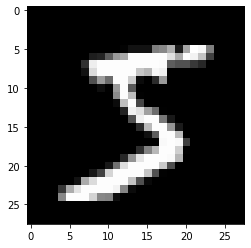

In [13]:
import matplotlib.pyplot as plt

with tf.device("CPU:0"):
    cpu_model = build_model(allow_cudnn_kernel=True)
    cpu_model.set_weights(model.get_weights())
    result = tf.argmax(cpu_model.predict_on_batch(tf.expand_dims(sample, 0)), axis=1)
    print(
        "Predicted result is: %s, target result is: %s" % (result.numpy(), sample_label)
    )
    plt.imshow(sample, cmap=plt.get_cmap("gray"))

## RNNs with list/dict inputs, or nested inputs

Nested structures allow implementers to include more information within a single
timestep. For example, a video frame could have audio and video input at the same
time. The data shape in this case could be:

`[batch, timestep, {"video": [height, width, channel], "audio": [frequency]}]`

In another example, handwriting data could have both coordinates x and y for the
current position of the pen, as well as pressure information. So the data
representation could be:

`[batch, timestep, {"location": [x, y], "pressure": [force]}]`

The following code provides an example of how to build a custom RNN cell that accepts
such structured inputs.

### Define a custom cell that supports nested input/output

See [Making new Layers & Models via subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models/)
for details on writing your own layers.

In [14]:
class NestedCell(keras.layers.Layer):
    def __init__(self, unit_1, unit_2, unit_3, **kwargs):
        self.unit_1 = unit_1
        self.unit_2 = unit_2
        self.unit_3 = unit_3
        self.state_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        self.output_size = [tf.TensorShape([unit_1]), tf.TensorShape([unit_2, unit_3])]
        super(NestedCell, self).__init__(**kwargs)

    def build(self, input_shapes):
        # expect input_shape to contain 2 items, [(batch, i1), (batch, i2, i3)]
        i1 = input_shapes[0][1]
        i2 = input_shapes[1][1]
        i3 = input_shapes[1][2]

        self.kernel_1 = self.add_weight(
            shape=(i1, self.unit_1), initializer="uniform", name="kernel_1"
        )
        self.kernel_2_3 = self.add_weight(
            shape=(i2, i3, self.unit_2, self.unit_3),
            initializer="uniform",
            name="kernel_2_3",
        )

    def call(self, inputs, states):
        # inputs should be in [(batch, input_1), (batch, input_2, input_3)]
        # state should be in shape [(batch, unit_1), (batch, unit_2, unit_3)]
        input_1, input_2 = tf.nest.flatten(inputs)
        s1, s2 = states

        output_1 = tf.matmul(input_1, self.kernel_1)
        output_2_3 = tf.einsum("bij,ijkl->bkl", input_2, self.kernel_2_3)
        state_1 = s1 + output_1
        state_2_3 = s2 + output_2_3

        output = (output_1, output_2_3)
        new_states = (state_1, state_2_3)

        return output, new_states

    def get_config(self):
        return {"unit_1": self.unit_1, "unit_2": unit_2, "unit_3": self.unit_3}


### Build a RNN model with nested input/output

Let's build a Keras model that uses a `keras.layers.RNN` layer and the custom cell
we just defined.

In [15]:
unit_1 = 10
unit_2 = 20
unit_3 = 30

i1 = 32
i2 = 64
i3 = 32
batch_size = 64
num_batches = 10
timestep = 50

cell = NestedCell(unit_1, unit_2, unit_3)
rnn = keras.layers.RNN(cell)

input_1 = keras.Input((None, i1))
input_2 = keras.Input((None, i2, i3))

outputs = rnn((input_1, input_2))

model = keras.models.Model([input_1, input_2], outputs)

model.compile(optimizer="adam", loss="mse", metrics=["accuracy"])

### Train the model with randomly generated data

Since there isn't a good candidate dataset for this model, we use random Numpy data for
demonstration.

In [16]:
input_1_data = np.random.random((batch_size * num_batches, timestep, i1))
input_2_data = np.random.random((batch_size * num_batches, timestep, i2, i3))
target_1_data = np.random.random((batch_size * num_batches, unit_1))
target_2_data = np.random.random((batch_size * num_batches, unit_2, unit_3))
input_data = [input_1_data, input_2_data]
target_data = [target_1_data, target_2_data]

model.fit(input_data, target_data, batch_size=batch_size)

 1/10 [==>...........................] - ETA: 6s - loss: 1.2815 - rnn_1_loss: 0.3630 - rnn_1_1_loss: 0.9185 - rnn_1_accuracy: 0.1250 - rnn_1_1_accuracy: 0.0492

 3/10 [========>.....................] - ETA: 0s - loss: 1.1137 - rnn_1_loss: 0.3501 - rnn_1_1_loss: 0.7636 - rnn_1_accuracy: 0.1189 - rnn_1_1_accuracy: 0.0436

 5/10 [==============>...............] - ETA: 0s - loss: 1.0396 - rnn_1_loss: 0.3413 - rnn_1_1_loss: 0.6983 - rnn_1_accuracy: 0.1184 - rnn_1_1_accuracy: 0.0413

 7/10 [====================>.........] - ETA: 0s - loss: 0.9909 - rnn_1_loss: 0.3341 - rnn_1_1_loss: 0.6567 - rnn_1_accuracy: 0.1155 - rnn_1_1_accuracy: 0.0400

10/10 [==============================] - ETA: 0s - loss: 0.9322 - rnn_1_loss: 0.3239 - rnn_1_1_loss: 0.6083 - rnn_1_accuracy: 0.1110 - rnn_1_1_accuracy: 0.0385

10/10 [==============================] - 1s 25ms/step - loss: 0.9178 - rnn_1_loss: 0.3211 - rnn_1_1_loss: 0.5968 - rnn_1_accuracy: 0.1097 - rnn_1_1_accuracy: 0.0382


With the Keras `keras.layers.RNN` layer, You are only expected to define the math
logic for individual step within the sequence, and the `keras.layers.RNN` layer
will handle the sequence iteration for you. It's an incredibly powerful way to quickly
prototype new kinds of RNNs (e.g. a LSTM variant).

For more details, please visit the [API docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN/).